In [1]:
import os
import numpy as np
import mido
import glob
from matplotlib import pyplot as plt

In [2]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

In [3]:
FILES_PATH = PROJECT_PATH + 'data/GiantMIDI-voices/'

In [4]:
mid = mido.MidiFile(FILES_PATH + 'Aloiz, Vladislav, 3 Morceaux, Op.33, CO3wGLavE4Y.mid')

In [5]:
def Note(tone, time, duration, velocity, dt):
    return [tone, time, duration, velocity, dt]

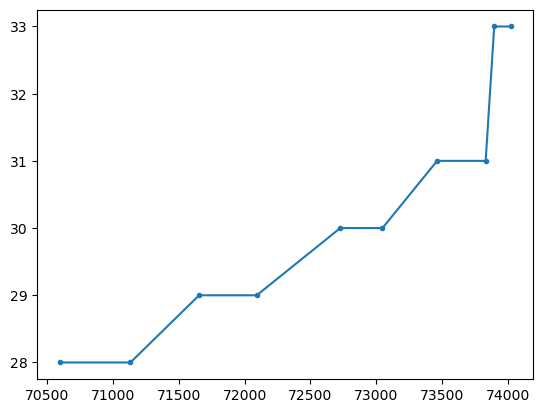

In [6]:
def graph():
    track = mid.tracks[0]

    x = [[]]
    y = [[]]

    time = 0
    for m in track:
        time += m.time
        #if m.type == 'note_on' and m.time > 1000:        
        #    x.append([])
        #    y.append([])
        if m.type == 'note_on' and m.velocity > 0:
            y[-1].append(m.note)
            x[-1].append(time)
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            y[-1].append(y[-1][-1])
            x[-1].append(time)

    for i in range(len(x)):
        plt.plot(x[i][:10], y[i][:10], '.-')
    plt.show()
    
graph()

In [7]:
LINE_MIN_LENGTH = 16
FIXED_LINE_LENGTH = 16

In [8]:
def track2line(track):
    line = []

    time = 0
    for m in track:
        time += m.time

        if m.type == 'note_on' and m.velocity > 0:
            if len(line) > 0:
                line[-1][4] = time - line[-1][1]
            line.append(Note(m.note, time, -1, m.velocity, -1))
            
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            i = 1
            while line[-i][0] != m.note:
                i += 1
            
            line[-i][2] = time - line[-1][1]
            
    return line

            
def split_line(line):
    lines = []
    prev = 0
    
    for i in range(1, len(line)):
        diff = line[i][1] - line[i - 1][1]
        
        if diff > 10000 or (line[i - 1][2] > 100 and line[i - 1][2] * 5 < diff):
            if i - prev > LINE_MIN_LENGTH:
                lines.append(line[prev:i])
                lines[-1][-1][4] = lines[-1][-1][2]
            prev = i
            
    if len(line) - prev > LINE_MIN_LENGTH:
        lines.append(line[prev:])
        
    return lines
            
    
def track2lines(track):
    line = track2line(track)
    splitted = split_line(line)
    
    return splitted


def mid2lines(mid):
    lines = []
    
    for t in mid.tracks:
        lines.extend(track2lines(t))
        
    return lines


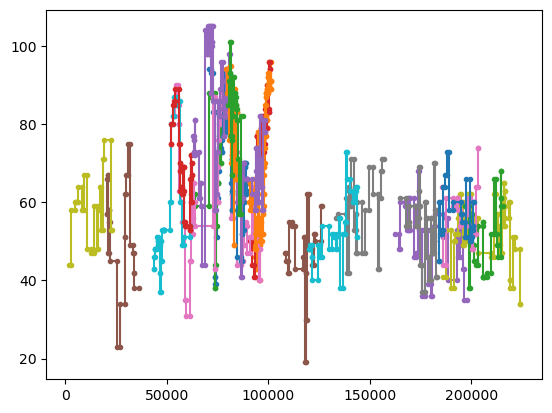

23


In [9]:
lines = mid2lines(mid)

for l in lines:
    x = []
    for i in l:
        x.extend([i[1], i[1] + i[4]])
        
    y = []
    for i in l:
        y.extend([i[3], i[3]])
    
    plt.plot(x, y, '.-')
    
plt.show()

print(len(lines))

In [10]:
from numpy.lib.stride_tricks import sliding_window_view

def stride_line(line):
    line = np.array(line, dtype=int)

    prev = line[0][0]
    line[0][0] = 0
    for i in range(1, len(line)):
        line[i][0] = line[i][0] - prev
        prev += line[i][0]

    line[..., 1] -= line[0][1]

    return np.squeeze(sliding_window_view(line, (FIXED_LINE_LENGTH, 5)))
    
def stride(lines):
    res = stride_line(lines[0])
    
    for l in lines[1:]:
        line_strided = stride_line(l)
        res = np.append(res, line_strided, axis=0)
    
    return res


In [11]:
np.set_printoptions(suppress=True)

strided = stride(lines)
print(strided.shape)
print(strided)

(306, 16, 5)
[[[   0    0  535   94 1057]
  [   1 1057  438   93 1072]
  [   1 2129  321   83  736]
  ...
  [  -2 6314   69   73  163]
  [   2 6477   66   80  352]
  [  -2 6829   98   77  322]]

 [[   1 1057  438   93 1072]
  [   1 2129  321   83  736]
  [   1 2865  369   41  434]
  ...
  [   2 6477   66   80  352]
  [  -2 6829   98   77  322]
  [   4 7151   48   83  158]]

 [[   1 2129  321   83  736]
  [   1 2865  369   41  434]
  [   2 3299  127   39  380]
  ...
  [  -2 6829   98   77  322]
  [   4 7151   48   83  158]
  [   0 7309   48   81  158]]

 ...

 [[   4 1376   38   77  130]
  [  -4 1506  219   87  230]
  [   0 1736  112   67  123]
  ...
  [   0 3841    4   84  584]
  [  -2 4425  113   81  290]
  [   2 4715   98   71  407]]

 [[  -4 1506  219   87  230]
  [   0 1736  112   67  123]
  [   4 1859   38   76  120]
  ...
  [  -2 4425  113   81  290]
  [   2 4715   98   71  407]
  [  -4 5122   23   57  942]]

 [[   0 1736  112   67  123]
  [   4 1859   38   76  120]
  [  -2 1979 

In [12]:
def process_file(fname):
    mid = mido.MidiFile(FILES_PATH + fname)
    
    lines = mid2lines(mid)
    if len(lines) > 0:
        strided = stride(lines)
        return strided


def process_files(filenames):
    res = process_file(filenames[0])
    
    for fname in filenames[1:]:
        processed = process_file(fname)
        if processed is not None:
            res = np.append(res, processed, axis=0)
        
    return res

In [13]:
res = process_files(os.listdir(FILES_PATH))
    
print(res.shape)

(5072011, 16, 5)


In [14]:
np.save(PROJECT_PATH + 'data/dset16.npy', res)

In [15]:
_ = plt.hist(res[..., 0].flatten(), bins=range(-20, 20))

In [16]:
_ = plt.hist(res[..., 3].flatten(), bins=100)

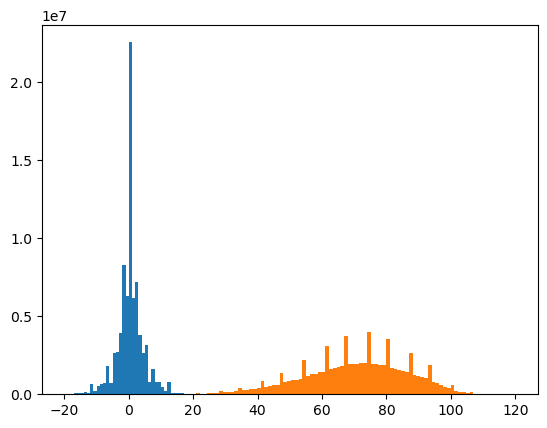

In [17]:
plt.show()